In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

from tensorflow.keras.preprocessing.image import load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
import tensorflow as tf


!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
fid = drive.ListFile({'q':"title='facemo.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('facemo.zip')
f.keys()
!unzip facemo.zip

In [2]:
gpus = tf.config.list_logical_devices('GPU') 
stg=tf.distribute.MirroredStrategy(gpus)

In [3]:
folder_path = "/content/facemo/images/" 
# folder_path = "../input/face-expression-recognition-dataset/images/"
# validation_folder_path = "../input/face-expression-recognition-dataset/images/"

In [4]:
import cv2
import os
from tqdm import tqdm

folder_dir = '/content/facemo/images/train'
SIZE = 75
DOWNSAMPLE_RATIO = 4
JPEG_QUALITY = 100

# get the total number of files to process
total_files = sum(len(files) for _, _, files in os.walk(folder_dir))

# use tqdm to display a progress bar
with tqdm(total=total_files, desc="Processing Images") as pbar:
    for folder in os.listdir(folder_dir):
        for file in os.listdir(os.path.join(folder_dir, folder)):
            if file.endswith("jpg"):
                image_path = os.path.join(folder_dir, folder, file)
                img = cv2.imread(image_path)
                img_resized = cv2.resize(img, (SIZE,SIZE))
                cv2.imwrite(image_path, img_resized)
                pbar.update(1) # increment the progress bar
            else:
                continue


Processing Images: 100%|██████████| 2827/2827 [00:02<00:00, 1364.59it/s]


In [5]:
'''
expression = 'happy'
plt.style.use('dark_background')
plt.figure(figsize=(12, 12))
for i in range(1, 10):
    plt.subplot(3, 3, i)
    img = load_img(folder_path + "train/" + expression + "/" + os.listdir(folder_path + "train/" + expression)[i], target_size=SIZE)
    plt.imshow(img)  
plt.show()
'''

'\nexpression = \'happy\'\nplt.style.use(\'dark_background\')\nplt.figure(figsize=(12, 12))\nfor i in range(1, 10):\n    plt.subplot(3, 3, i)\n    img = load_img(folder_path + "train/" + expression + "/" + os.listdir(folder_path + "train/" + expression)[i], target_size=SIZE)\n    plt.imshow(img)  \nplt.show()\n'

In [6]:
batch_size = 32
picture_size = (SIZE,SIZE)
datagen_train = ImageDataGenerator(rotation_range=.5, 
                                    width_shift_range=0.2, 
                                    height_shift_range=0.2, 
                                    zoom_range=0.2, 
                                    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input 
                                )

datagen_val = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input )

train_datagen = ImageDataGenerator(rescale=1./255,
                                    rotation_range=.5,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    zoom_range=0.2,
                                    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
train_generator = train_datagen.flow_from_directory(folder_path + 'train',
                                                    target_size=(picture_size),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

validation_set = test_datagen.flow_from_directory(folder_path + 'validation',
                                                        target_size=(picture_size),
                                                        batch_size=batch_size,
                                                        class_mode='categorical')

Found 2827 images belonging to 5 classes.
Found 797 images belonging to 5 classes.


In [8]:

from tensorflow.keras.optimizers import Adam,SGD,RMSprop
from tensorflow.keras.optimizers import RMSprop,SGD,Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


no_of_classes = 5

with stg.scope():
    base_model = tf.keras.applications.Xception(weights="imagenet",
                                            input_shape=(SIZE, SIZE, 3),
                                            include_top=False,)
    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(no_of_classes, activation='softmax'))

    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(lr=0.001),
        metrics=['accuracy'])

model.summary()

83683744/83683744 [==============================] - 5s 0us/step


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                        

In [9]:
early_stopping = EarlyStopping(monitor='val_loss',
                                patience=3,
                                verbose=1,
                                restore_best_weights=True)

lr_scheduler = ReduceLROnPlateau(monitor='val_loss',
                                 factor=0.1,
                                 patience=2,
                                 verbose=1)

callbacks = [early_stopping, lr_scheduler]


In [10]:
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.n // batch_size,
                    epochs=32,
                    validation_data=validation_set,
                    validation_steps=validation_set.n // batch_size,
                    callbacks=callbacks)

Epoch 1/32
88/88 [==============================] - 31s 210ms/step - loss: 1.1665 - accuracy: 0.5571 - val_loss: 0.9137 - val_accuracy: 0.6172 - lr: 0.0010
Epoch 2/32
88/88 [==============================] - 9s 99ms/step - loss: 0.6759 - accuracy: 0.7445 - val_loss: 0.6264 - val_accuracy: 0.6927 - lr: 0.0010
Epoch 3/32
88/88 [==============================] - 7s 82ms/step - loss: 0.5164 - accuracy: 0.8079 - val_loss: 0.4261 - val_accuracy: 0.8516 - lr: 0.0010
Epoch 4/32
88/88 [==============================] - 7s 81ms/step - loss: 0.4201 - accuracy: 0.8419 - val_loss: 0.4369 - val_accuracy: 0.8242 - lr: 0.0010
Epoch 5/32
88/88 [==============================] - 8s 91ms/step - loss: 0.3535 - accuracy: 0.8733 - val_loss: 0.3359 - val_accuracy: 0.9049 - lr: 0.0010
Epoch 6/32
88/88 [==============================] - 8s 92ms/step - loss: 0.3040 - accuracy: 0.8977 - val_loss: 0.2500 - val_accuracy: 0.8971 - lr: 0.0010
Epoch 7/32
88/88 [==============================] - 9s 99ms/step - loss: 0

In [11]:
model.trainable = True

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.00001), metrics=['accuracy'])

last_epoch = 20
# Fine-tune the model on your dataset
history = model.fit(train_generator, epochs=40, validation_data=validation_set, callbacks=[early_stopping,lr_scheduler], 
                    steps_per_epoch=len(train_generator), validation_steps=len(validation_set), 
                    initial_epoch=last_epoch)

Epoch 21/40
89/89 [==============================] - 48s 140ms/step - loss: 0.6635 - accuracy: 0.7807 - val_loss: 13.4080 - val_accuracy: 0.6110 - lr: 0.0010
Epoch 22/40
89/89 [==============================] - 10s 113ms/step - loss: 0.3200 - accuracy: 0.9169 - val_loss: 1.9066 - val_accuracy: 0.7955 - lr: 0.0010
Epoch 23/40
89/89 [==============================] - 10s 113ms/step - loss: 0.1745 - accuracy: 0.9561 - val_loss: 0.5969 - val_accuracy: 0.9435 - lr: 0.0010
Epoch 24/40
89/89 [==============================] - 10s 110ms/step - loss: 0.1521 - accuracy: 0.9597 - val_loss: 1.4762 - val_accuracy: 0.8984 - lr: 0.0010
Epoch 25/40
89/89 [==============================] - ETA: 0s - loss: 0.2136 - accuracy: 0.9484
Epoch 25: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
89/89 [==============================] - 9s 99ms/step - loss: 0.2136 - accuracy: 0.9484 - val_loss: 1.1717 - val_accuracy: 0.8105 - lr: 0.0010
Epoch 26/40
89/89 [==============================] - 10

In [14]:
test_loss, test_acc = model.evaluate(validation_set)
print('Test accuracy:', test_acc)

25/25 [==============================] - 1s 27ms/step - loss: 0.0264 - accuracy: 0.9875
Test accuracy: 0.9874529242515564


In [16]:
model.trainable = False
for layer in base_model.layers[:10]:
  layer.trainable = True

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.00001), metrics=['accuracy'])

last_epoch = 31
# Fine-tune the model on your dataset
history = model.fit(train_generator, epochs=42, validation_data=validation_set, callbacks=[early_stopping,lr_scheduler], 
                    steps_per_epoch=len(train_generator), validation_steps=len(validation_set), 
                    initial_epoch=last_epoch)

Epoch 32/42
89/89 [==============================] - 14s 121ms/step - loss: 0.0145 - accuracy: 0.9968 - val_loss: 0.0243 - val_accuracy: 0.9875 - lr: 0.0010
Epoch 33/42
89/89 [==============================] - 8s 86ms/step - loss: 0.0184 - accuracy: 0.9954 - val_loss: 0.0241 - val_accuracy: 0.9875 - lr: 0.0010
Epoch 34/42
89/89 [==============================] - 8s 90ms/step - loss: 0.0145 - accuracy: 0.9958 - val_loss: 0.0240 - val_accuracy: 0.9875 - lr: 0.0010
Epoch 35/42
89/89 [==============================] - ETA: 0s - loss: 0.0134 - accuracy: 0.9961
Epoch 35: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
89/89 [==============================] - 8s 90ms/step - loss: 0.0134 - accuracy: 0.9961 - val_loss: 0.0240 - val_accuracy: 0.9875 - lr: 0.0010
Epoch 36/42
89/89 [==============================] - 8s 95ms/step - loss: 0.0126 - accuracy: 0.9972 - val_loss: 0.0242 - val_accuracy: 0.9875 - lr: 1.0000e-04
Epoch 37/42
89/89 [==============================] - ETA: 

In [17]:
test_loss, test_acc = model.evaluate(validation_set)
print('Test accuracy:', test_acc)

25/25 [==============================] - 1s 28ms/step - loss: 0.0240 - accuracy: 0.9875
Test accuracy: 0.9874529242515564


0 = Angry
1 = Happy
2 = Neutral
3 = Sad
4 = Surprise
1/1 [==============================] - 1s 909ms/step


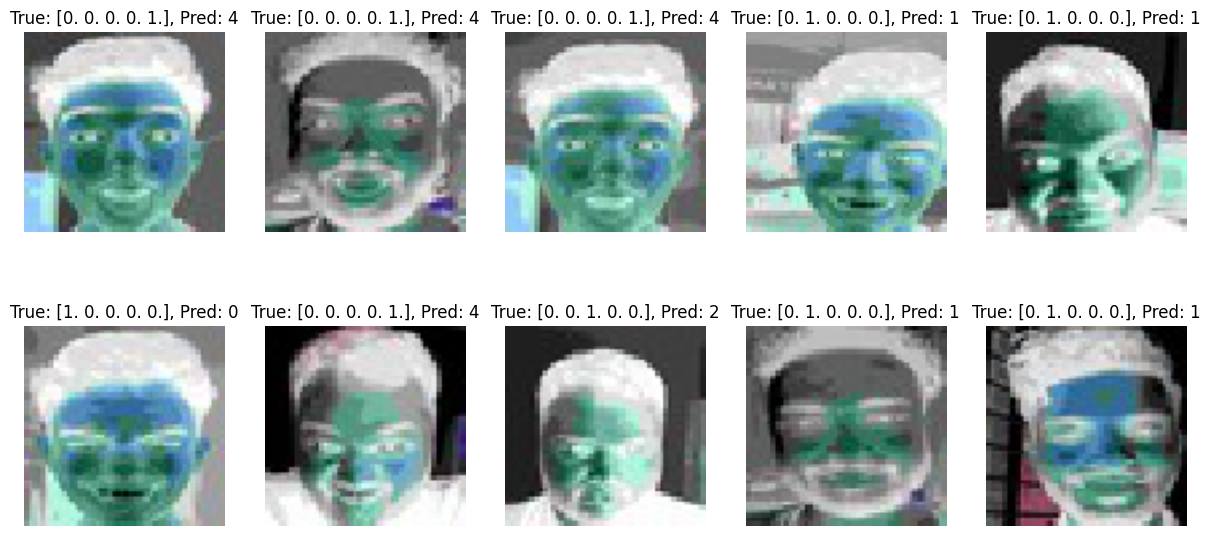

In [18]:
import numpy as np
import matplotlib.pyplot as plt
e = ['Angry','Happy','Neutral','Sad','Surprise']
for i in range(len(e)):
    print(i,"=",e[i])
# Get a batch of 10 random images from the test set
test_batch = validation_set.next()
images = test_batch[0][:10]
true_labels = test_batch[1][:10]

# Make predictions using the trained model
pred_probs = model.predict(images)
pred_labels = np.argmax(pred_probs, axis=1)

# Plot the images with their true and predicted labels
fig, axs = plt.subplots(2, 5, figsize=(15, 7))
axs = axs.flatten()

for i in range(len(images)):
    # Rescale the pixel values from [0, 1] to [0, 255] and convert to integers
    img = (images[i] * 255).astype(np.uint8)
    # Invert the pixel values
    img = 255 - img
    axs[i].imshow(img)
    axs[i].set_title(f'True: {true_labels[i]}, Pred: {pred_labels[i]}')
    axs[i].axis('off')

plt.show()

